In [1]:
import numpy as np
import xray
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (4096 ,4096 ))
resource.getrlimit(resource.RLIMIT_NOFILE)


(4096, 4096)

In [3]:
import xgcm

In [7]:
iters = range(480, 210240, 480)
ddir = '/data/scratch/rpa/SOSE/run_np240'
sose = xray.decode_cf(xgcm.open_mdsdataset(ddir, iters, prefix=['DiagIce-5day',],
                             deltaT=900, ref_date='2005-01-01 00:00:00', calendar='gregorian'))
#sose = xray.decode_cf(xray.Dataset.load_store(store))

In [5]:
from mpl_toolkits.basemap import Basemap
def southern_ocean_pcolormesh(d, boundinglat=-60., ax=None,
                              spatial_coords = ('X', 'Y'),
                              labels=[1,0,0,1], maskwhere=None,
                              land=True, grid=True, **kwargs):
    """Plot something in the southern ocean."""
    
    m = Basemap(projection='spstere',boundinglat=boundinglat, lon_0=180., ax=ax)
    if land:
        m.drawcoastlines()
        m.fillcontinents(color='0.7',lake_color='0.5')
    # draw parallels and meridians.
    if grid:
        m.drawparallels(np.arange(-80.,81.,10.))
        m.drawmeridians(np.arange(-180.,181.,30.), labels=labels)
    m.drawmapboundary(fill_color='0.2')
    #x, y = m(nc.variables['TLON'][:], nc.variables['TLAT'][:])
    lon, lat = [d[sc].values for sc in spatial_coords]
    if lon.ndim==1:
        lon, lat = np.meshgrid(lon, lat)
    x, y = m(lon, lat)
    if maskwhere is None:
        v = np.ma.masked_invalid(d.values)
    else:
        v = np.ma.masked_equal(
                np.ma.masked_invalid(d.values), maskwhere)
    return m.pcolormesh(x, y, v, **kwargs), m

In [8]:
SIarea = sose.SIarea.resample('MS', 'time')

In [9]:
basedir = '/data/scratch/rpa/nsidc'
nsidc = xray.open_dataset(os.path.join(basedir, 'nsidc0051_gsfc_nasateam_seaice_final-gsfc_south_monthly.nc'))
area_nsidc = nsidc.ice_concentration.resample('MS', 'time')

# Ice Concentration Validation #
### Sea Ice Concentrations from Nimbus-7 SMMR and DMSP SSM/I-SSMIS Passive Microwave Data ###

http://nsidc.org/data/nsidc-0051

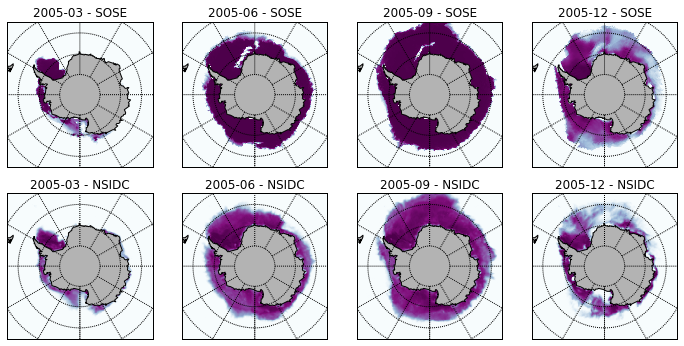

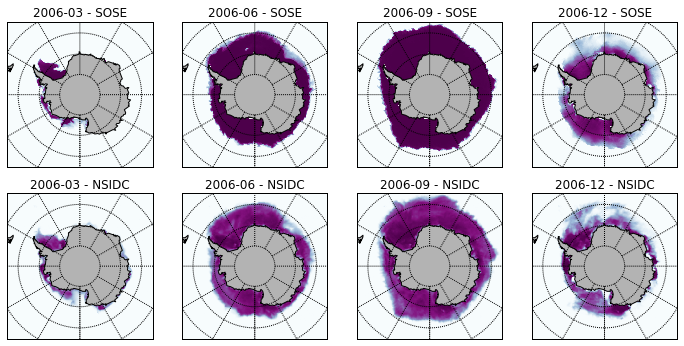

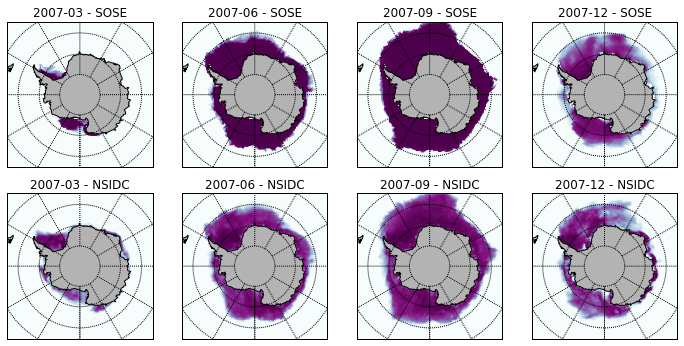

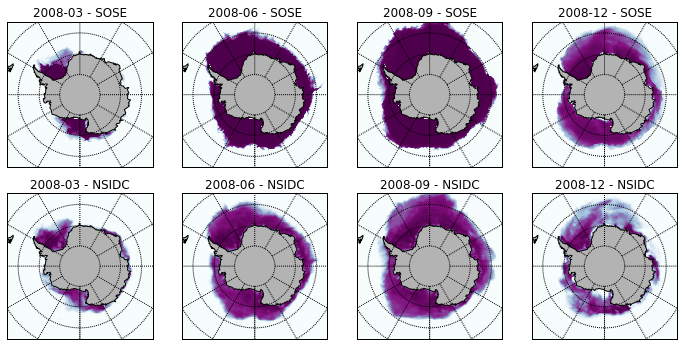

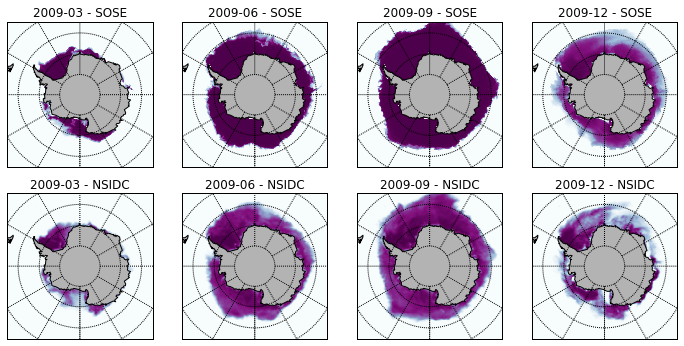

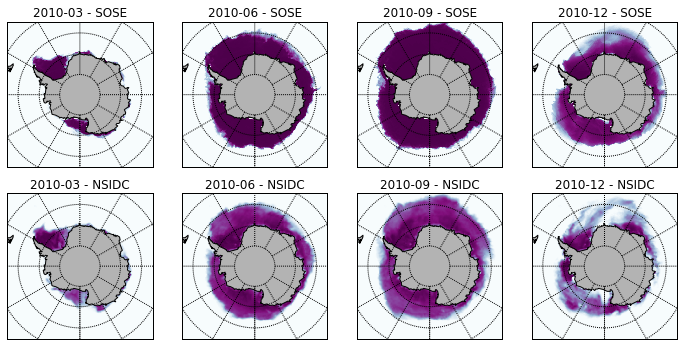

In [10]:
for year in range(2005,2011):
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.9,
                        wspace=0.05, hspace=0.18)
    
    for nm, month in enumerate([3,6,9,12]):
        date = '%04d-%02d' % (year, month)
        for n, (da, coords, name) in enumerate(zip(
                        [SIarea, area_nsidc],
                        [('X','Y'), ('lon', 'lat')],
                        ['SOSE', 'NSIDC'])):
            plt.subplot(2,4,(4*n)+nm+1)
            pc, m = southern_ocean_pcolormesh(da.sel(time=date+'-01', method='nearest'),
                                              spatial_coords = coords, labels=[0,0,0,0],
                                              boundinglat=-55, cmap='BuPu')
            plt.title('%s - %s' % (date, name))
            #plt.colorbar(shrink=0.6)
            plt.clim([0,1])
    #plt.tight_layout()
    plt.show()

In [152]:
icesat = xray.open_dataset('/data/scratch/rpa/ICESat/interp_grids.nc')
icesat.season.values

array(['ON03', 'FM04', 'MJ04', 'ON04', 'FM05', 'MJ05', 'ON05', 'FM06',
       'MJ06', 'ON06', 'MA07', 'ON07', 'FM08'], 
      dtype='|S4')

In [181]:
# now sample SOSE in the same way
# ON= October-November, MJ = May-June, FM = February-March, MA=March-April
months = {'ON': (10,12), 'MJ': (5,7), 'FM': (2,4), 'MA': (3,5)}
df = []
for s in icesat.season.values:
    m = s[:2]
    year = int(s[2:]) + 2000
    lims = ['%s-%02d-01' % (year, mon) for mon in months[m]]
    d = sose.SIheff.sel(time=slice(*lims)).mean(dim='time')
    if not np.all(d.isnull()):
        d.coords['season'] = s
        df.append(d)
sose_season = xray.concat(df, dim='season').to_dataset(name='thickness')

# Ice Thickness Validation #
### Sea ice thickness data derived from ICESat laser altimetry data###

Data consist of 13 measurement campaigns spanning the time period from October 2003 to March 2008.

http://neptune.gsfc.nasa.gov/csb/index.php?section=272

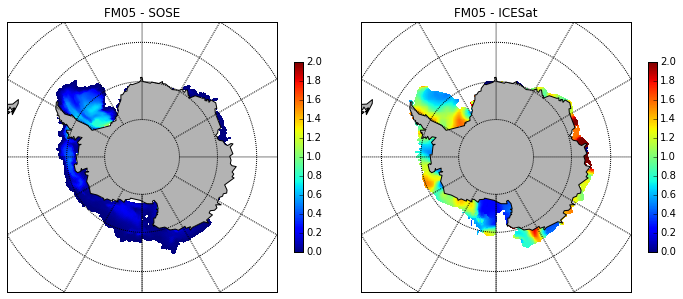

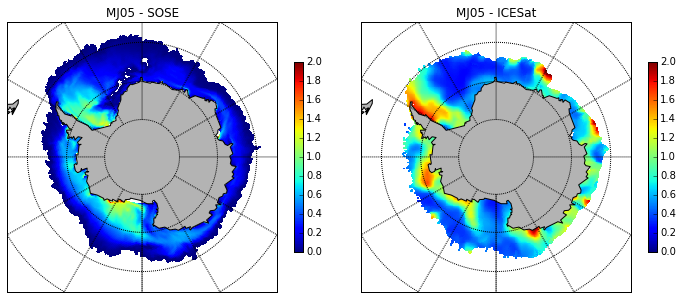

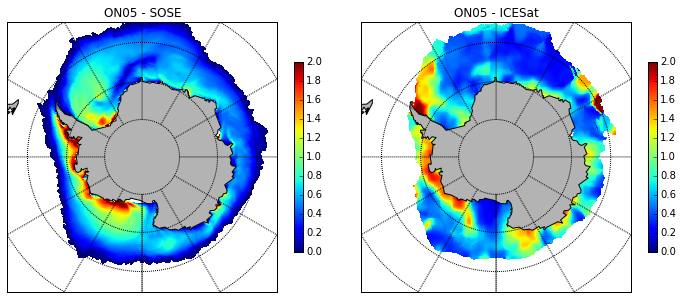

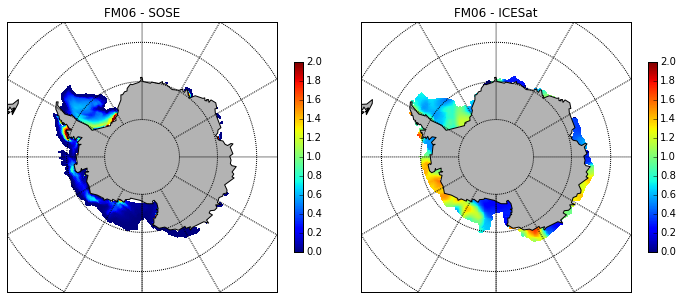

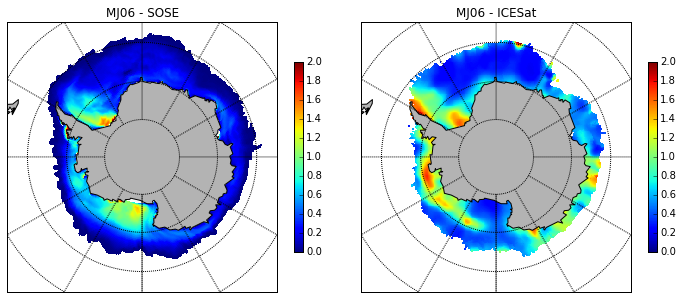

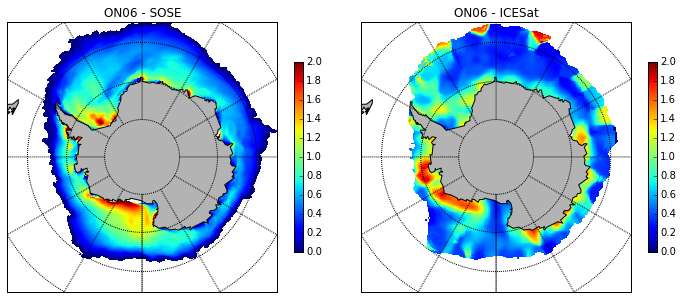

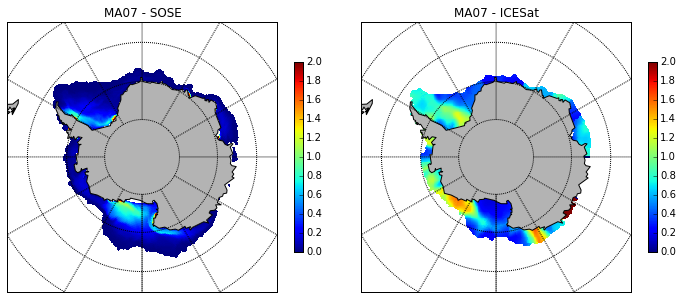

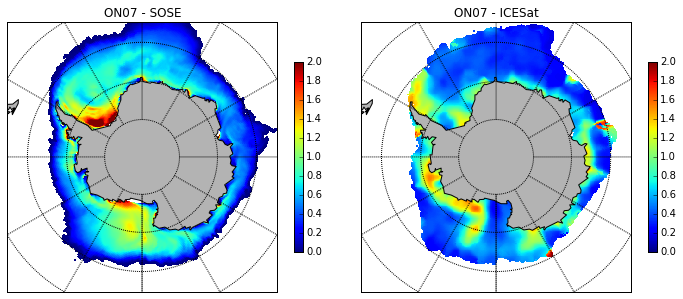

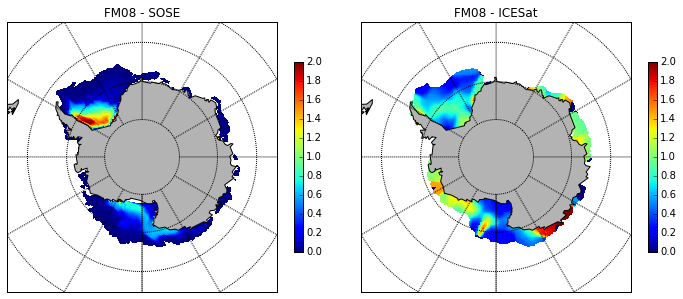

In [197]:
for s in sose_season.season.values:
    plt.figure(figsize=(10,5))
    plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.9,
                        wspace=0.05, hspace=0.18)
    
    for n, (da, coords, name) in enumerate(zip(
                    [sose_season.thickness, icesat.thickness],
                    [('X','Y'), ('lon', 'lat')],
                    ['SOSE', 'ICESat'])):
        plt.subplot(1,2,n+1)
        pc, m = southern_ocean_pcolormesh(da.sel(season=s),
                                          spatial_coords = coords, labels=[0,0,0,0],
                                          boundinglat=-55, cmap='jet', maskwhere=0.)
        plt.title('%s - %s' % (s, name))
        plt.colorbar(shrink=0.6)
        plt.clim([0,2])
    #plt.tight_layout()
    plt.show()